In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit, StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV ,SGDClassifier
import seaborn as sns
import warnings
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay, accuracy_score, matthews_corrcoef
from sklearn.preprocessing import MinMaxScaler

In [2]:
warnings.filterwarnings('ignore')

In [3]:
file_path = './datasets/datos_CB.csv'
student_data = pd.read_csv(file_path,index_col=0)
student_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 97341 entries, 401 to 12388
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   ciclo         97341 non-null  int64  
 1   Asignatura    97341 non-null  int64  
 2   Cod.Car.Sec   97341 non-null  int64  
 3   Convocatoria  97341 non-null  int64  
 4   Anho          97341 non-null  int64  
 5   Aprobado      97341 non-null  int64  
 6   Anho.Firma    97341 non-null  int64  
 7   Primer.Par    97341 non-null  int64  
 8   Segundo.Par   97341 non-null  int64  
 9   AOT           97341 non-null  int64  
 10  Nota.Final    97341 non-null  object 
 11  id_anony      97341 non-null  int64  
 12  Nota.Prom     97341 non-null  float64
 13  Firma         97341 non-null  bool   
dtypes: bool(1), float64(1), int64(11), object(1)
memory usage: 10.5+ MB


In [4]:
def get_course(student_data,course):
    condition = student_data["Asignatura"] == identifiers["Asignatura"][course]
    course_data = student_data[condition]
    course_data.drop(["Nota.Prom"],axis=1, inplace = True)
    print("\n",len(course_data))
    course_data.head()
    return course_data

In [5]:
columns = ["Cod.Car.Sec","Asignatura","id_anony"]
identifiers = {}
for column in columns:
    file_path = f'./datasets/identificador de {column}.csv'
    df = pd.read_csv(file_path,index_col=0)
    identifiers[column] = df.to_dict()['Code']
#identifiers["Asignatura"]

In [6]:
course_data = get_course(student_data,"ESTATICA")
course_data.head()


 4824


,ciclo,Asignatura,Cod.Car.Sec,Convocatoria,Anho,Aprobado,Anho.Firma,Primer.Par,Segundo.Par,AOT,Nota.Final,id_anony,Firma
1744,2,89,4,1,2012,0,0,2,13,0,[0],4087,False
1745,2,89,4,1,2012,0,0,6,11,0,[0],4099,False
1746,2,89,3,1,2012,1,2012,12,24,0,[2],833,True
1747,2,89,3,1,2012,0,0,1,1,0,[0],4733,False
1748,2,89,1,1,2012,0,0,0,0,0,[0],528,False


In [7]:
def count_attemps(course_data):
    course_data = course_data.sort_values(by=['id_anony','Anho'])
    last_id = course_data['id_anony'].iloc[0]
    counter = 0
    for index,row in course_data.iterrows():
        #print(index)
        if row['id_anony'] == last_id:
            counter += 1 
            course_data.loc[index,['Num.Intento']] = counter
        else:
            last_id = row['id_anony']
            course_data.loc[index,['Num.Intento']] = 1
            counter = 1
    return course_data

In [8]:
course_data = count_attemps(course_data)

In [9]:
def get_previous_course(previous_course):
    #slicing
    formated_title = str.title(previous_course.lower().replace(' ', '_'))
    condition = student_data["Asignatura"] == identifiers["Asignatura"][previous_course]
    previous_course_data = student_data[condition]
    previous_course_data = count_attemps(previous_course_data)
    previous_course_data = previous_course_data.rename(columns={'Num.Intento':f'Num.Intento.{formated_title}', 'Nota.Prom' : f'Nota.Prom.{formated_title}'})
    previous_course_data = previous_course_data[["id_anony", f'Nota.Prom.{formated_title}', f'Num.Intento.{formated_title}']]
    
    #grouping by id
    attemps = previous_course_data[['id_anony',f'Num.Intento.{formated_title}']].groupby(['id_anony']).max()
    avg_grade = previous_course_data[['id_anony',f'Nota.Prom.{formated_title}']].groupby(['id_anony']).mean()
    result = pd.concat([avg_grade,attemps],axis=1)
    #result
    
    return result

In [10]:
def merge_previous_course(course_data,result):
    result = pd.merge(course_data, result, on = 'id_anony', how = 'left')
    #for col in result.columns:
    #    print(col,np.unique(result[col]))
    return result


In [11]:
def getNans(result,interpolation):
    if interpolation:
        course = result.columns[-1][12:] #get the previous course name
        print("Mean grade with NaN:",np.mean(result.iloc[:,-2]),"Mean attemps with NaN:",np.mean(result.iloc[:,-1]))
        result[f'Nota.Prom.{course}'] = result[f'Nota.Prom.{course}'].fillna(result['Primer.Par']/24*5) #averagin from first midterm
        result[f'Num.Intento.{course}'] = result[f'Num.Intento.{course}'].fillna(np.mean(result[f'Num.Intento.{course}']))
        print('Mean grade interpolated',np.mean(result[f'Nota.Prom.{course}']),'Mean attemps interpolated',np.mean(result[f'Num.Intento.{course}']))


In [12]:
def add_course(course_data, previous_course, interpolation = True):
    previous_course_data = get_previous_course(previous_course)
    result = merge_previous_course(course_data,previous_course_data)
    getNans(result,interpolation)
    original = result.copy()
    y = result['Aprobado']
    result.drop(['ciclo','Asignatura','Aprobado','Segundo.Par','AOT','Anho.Firma','Nota.Final','id_anony'],axis=1,inplace = True)
    return result,y,original

In [13]:
result,y,original = add_course(course_data,'ALGEBRA LINEAL 2', interpolation=False)

In [14]:
result.head()

,Cod.Car.Sec,Convocatoria,Anho,Primer.Par,Firma,Num.Intento,Nota.Prom.Algebra_Lineal_2,Num.Intento.Algebra_Lineal_2
0,5,1,2012,6,False,1.0,NaN,NaN
1,5,1,2013,6,True,1.0,NaN,NaN
2,5,1,2012,15,True,1.0,NaN,NaN
3,1,1,2012,10,True,1.0,NaN,NaN
4,1,1,2013,8,True,3.0,NaN,NaN


# XGBoost
## With a specific course

In [15]:
from xgboost import XGBClassifier

params = ['binary:logistic', 'binary:hinge']

for param in params:
    clf_xgb = XGBClassifier(objective = param, seed=10, eval_metric="logloss")

    result,y,original = add_course(course_data,'ALGEBRA LINEAL 2',interpolation=False)

    X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)

    pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
    preds_xgb = clf_xgb.predict(X_test)
    accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
    print('Accuracy de XGBoost: ', accuracy_xgb)
    print('Mathews correlation: ',matthews_corrcoef(y_test,preds_xgb))
    print("\n")

[0]	validation_0-logloss:0.53032
[1]	validation_0-logloss:0.43463
[2]	validation_0-logloss:0.37874
[3]	validation_0-logloss:0.33914
[4]	validation_0-logloss:0.31306
[5]	validation_0-logloss:0.29364
[6]	validation_0-logloss:0.28081
[7]	validation_0-logloss:0.27070
[8]	validation_0-logloss:0.26452
[9]	validation_0-logloss:0.25935
[10]	validation_0-logloss:0.25598
[11]	validation_0-logloss:0.25256
[12]	validation_0-logloss:0.25113
[13]	validation_0-logloss:0.25021
[14]	validation_0-logloss:0.24974
[15]	validation_0-logloss:0.24943
[16]	validation_0-logloss:0.24942
[17]	validation_0-logloss:0.24895
[18]	validation_0-logloss:0.24930
[19]	validation_0-logloss:0.24896
[20]	validation_0-logloss:0.24842
[21]	validation_0-logloss:0.24938
[22]	validation_0-logloss:0.24942
[23]	validation_0-logloss:0.24912
[24]	validation_0-logloss:0.24952
[25]	validation_0-logloss:0.24986
[26]	validation_0-logloss:0.25195
[27]	validation_0-logloss:0.25260
[28]	validation_0-logloss:0.25223
[29]	validation_0-loglos

## With the whole common course dataset

In [16]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', seed=10, eval_metric="auc")
y = student_data['Aprobado']
x = student_data.drop(['ciclo','Segundo.Par','AOT','Nota.Final','id_anony','Nota.Prom','Aprobado'],axis=1)
#print(x.head())
X_train, X_test, y_train, y_test = train_test_split(x, y, random_state=10, test_size=0.2)
pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=5, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)
print('Mathews correlation: ',matthews_corrcoef(y_test,preds_xgb))
print("\n")

[0]	validation_0-auc:0.91870
[1]	validation_0-auc:0.92045
[2]	validation_0-auc:0.92148
[3]	validation_0-auc:0.92223
[4]	validation_0-auc:0.92333
[5]	validation_0-auc:0.92424
[6]	validation_0-auc:0.92473
[7]	validation_0-auc:0.92529
[8]	validation_0-auc:0.92568
[9]	validation_0-auc:0.92627
[10]	validation_0-auc:0.92674
[11]	validation_0-auc:0.92723
[12]	validation_0-auc:0.92735
[13]	validation_0-auc:0.92728
[14]	validation_0-auc:0.92805
[15]	validation_0-auc:0.92863
[16]	validation_0-auc:0.92906
[17]	validation_0-auc:0.92903
[18]	validation_0-auc:0.92919
[19]	validation_0-auc:0.92938
[20]	validation_0-auc:0.92975
[21]	validation_0-auc:0.93026
[22]	validation_0-auc:0.93038
[23]	validation_0-auc:0.93038
[24]	validation_0-auc:0.93045
[25]	validation_0-auc:0.93059
[26]	validation_0-auc:0.93091
[27]	validation_0-auc:0.93166
[28]	validation_0-auc:0.93207
[29]	validation_0-auc:0.93210
[30]	validation_0-auc:0.93222
[31]	validation_0-auc:0.93233
[32]	validation_0-auc:0.93246
[33]	validation_0-au

# With a scaler
## All common courses

In [17]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', seed=10, eval_metric="logloss")
scaler = MinMaxScaler(feature_range=(0,1))
y = student_data['Aprobado']
x = student_data.drop(['ciclo','Segundo.Par','AOT','Nota.Final','id_anony','Nota.Prom','Aprobado'],axis=1)
#print(x.head())
xnorm = scaler.fit_transform(x)
#print(xnorm)
X_train, X_test, y_train, y_test = train_test_split(xnorm, y, random_state=10, test_size=0.2)
pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)
print('Mathews correlation: ',matthews_corrcoef(y_test,preds_xgb))
print("\n")

[0]	validation_0-logloss:0.53960
[1]	validation_0-logloss:0.45620
[2]	validation_0-logloss:0.40545
[3]	validation_0-logloss:0.37305
[4]	validation_0-logloss:0.35106
[5]	validation_0-logloss:0.33602
[6]	validation_0-logloss:0.32558
[7]	validation_0-logloss:0.31824
[8]	validation_0-logloss:0.31299
[9]	validation_0-logloss:0.30881
[10]	validation_0-logloss:0.30583
[11]	validation_0-logloss:0.30350
[12]	validation_0-logloss:0.30194
[13]	validation_0-logloss:0.30094
[14]	validation_0-logloss:0.29928
[15]	validation_0-logloss:0.29805
[16]	validation_0-logloss:0.29702
[17]	validation_0-logloss:0.29668
[18]	validation_0-logloss:0.29624
[19]	validation_0-logloss:0.29580
[20]	validation_0-logloss:0.29528
[21]	validation_0-logloss:0.29450
[22]	validation_0-logloss:0.29427
[23]	validation_0-logloss:0.29419
[24]	validation_0-logloss:0.29398
[25]	validation_0-logloss:0.29381
[26]	validation_0-logloss:0.29328
[27]	validation_0-logloss:0.29231
[28]	validation_0-logloss:0.29167
[29]	validation_0-loglos

# Specific course

In [18]:
clf_xgb = XGBClassifier(objective = 'binary:logistic', seed=10, eval_metric="logloss")
result,y,original = add_course(course_data,'ALGEBRA LINEAL 2',interpolation=False)
result = scaler.fit_transform(result)
X_train, X_test, y_train, y_test = train_test_split(result, y, random_state=10)
pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
print('Accuracy de XGBoost: ', accuracy_xgb)
print('Mathews correlation: ',matthews_corrcoef(y_test,preds_xgb))
print("\n")

[0]	validation_0-logloss:0.53032
[1]	validation_0-logloss:0.43463
[2]	validation_0-logloss:0.37874
[3]	validation_0-logloss:0.33914
[4]	validation_0-logloss:0.31306
[5]	validation_0-logloss:0.29364
[6]	validation_0-logloss:0.28081
[7]	validation_0-logloss:0.27070
[8]	validation_0-logloss:0.26452
[9]	validation_0-logloss:0.25935
[10]	validation_0-logloss:0.25598
[11]	validation_0-logloss:0.25256
[12]	validation_0-logloss:0.25104
[13]	validation_0-logloss:0.25012
[14]	validation_0-logloss:0.24963
[15]	validation_0-logloss:0.24932
[16]	validation_0-logloss:0.24931
[17]	validation_0-logloss:0.24884
[18]	validation_0-logloss:0.24919
[19]	validation_0-logloss:0.24885
[20]	validation_0-logloss:0.24832
[21]	validation_0-logloss:0.24927
[22]	validation_0-logloss:0.24931
[23]	validation_0-logloss:0.24902
[24]	validation_0-logloss:0.24942
[25]	validation_0-logloss:0.24976
[26]	validation_0-logloss:0.25184
[27]	validation_0-logloss:0.25232
[28]	validation_0-logloss:0.25196
[29]	validation_0-loglos

# Comparing with old dataset (All courses)

In [19]:
data= pd.read_csv("./datasets/Filtrado_finalNew.csv",sep=",",index_col=False)
data['Anho']=data['Anho'].values-2012
features=['Asignatura Codificada','Cod.Car.Sec Codificado','Recursante','Anho','1P','Aprobado']
df=data[features]
X=df.drop('Aprobado',axis=1)
y=df[['Aprobado']]
y=np.ravel(np.array(y))
Xnorm = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(Xnorm,y,test_size=0.20, random_state=10)
model = XGBClassifier(objective = 'binary:logistic', seed=10, eval_metric='logloss')
model.fit(X_train, y_train)
y_pred = model.predict(x_test)
acc = accuracy_score(y_test,y_pred)
print(acc)
print(matthews_corrcoef(y_test,y_pred))

0.8862009509378755
0.7769389987387314


# XGB Trees tuning

Best: 0.909730 using {'n_estimators': 40}
0.908076 (0.001476) with: {'n_estimators': 1}
0.907936 (0.001373) with: {'n_estimators': 2}
0.908003 (0.001384) with: {'n_estimators': 3}
0.908100 (0.001378) with: {'n_estimators': 4}
0.908173 (0.001474) with: {'n_estimators': 5}
0.908238 (0.001625) with: {'n_estimators': 6}
0.908380 (0.001364) with: {'n_estimators': 7}
0.908499 (0.001295) with: {'n_estimators': 8}
0.908411 (0.001316) with: {'n_estimators': 9}
0.908533 (0.001424) with: {'n_estimators': 10}
0.908538 (0.001359) with: {'n_estimators': 11}
0.908487 (0.001275) with: {'n_estimators': 12}
0.908702 (0.001221) with: {'n_estimators': 13}
0.908622 (0.001178) with: {'n_estimators': 14}
0.908684 (0.001158) with: {'n_estimators': 15}
0.908716 (0.001157) with: {'n_estimators': 16}
0.908664 (0.001199) with: {'n_estimators': 17}
0.908676 (0.001134) with: {'n_estimators': 18}
0.908670 (0.001242) with: {'n_estimators': 19}
0.908704 (0.001312) with: {'n_estimators': 20}
0.908754 (0.001344) with: {

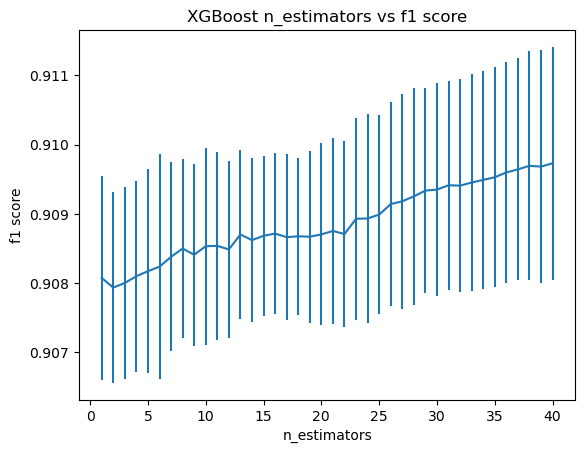

Best: -0.266776 using {'n_estimators': 40}
-0.527791 (0.000804) with: {'n_estimators': 1}
-0.438459 (0.001408) with: {'n_estimators': 2}
-0.384601 (0.001883) with: {'n_estimators': 3}
-0.350511 (0.002215) with: {'n_estimators': 4}
-0.328150 (0.002618) with: {'n_estimators': 5}
-0.313168 (0.002818) with: {'n_estimators': 6}
-0.303029 (0.003011) with: {'n_estimators': 7}
-0.295964 (0.003207) with: {'n_estimators': 8}
-0.290845 (0.003212) with: {'n_estimators': 9}
-0.287164 (0.003267) with: {'n_estimators': 10}
-0.284387 (0.003459) with: {'n_estimators': 11}
-0.282212 (0.003653) with: {'n_estimators': 12}
-0.280475 (0.003582) with: {'n_estimators': 13}
-0.278910 (0.003677) with: {'n_estimators': 14}
-0.277777 (0.003715) with: {'n_estimators': 15}
-0.276823 (0.003859) with: {'n_estimators': 16}
-0.275909 (0.003886) with: {'n_estimators': 17}
-0.275213 (0.003951) with: {'n_estimators': 18}
-0.274504 (0.004093) with: {'n_estimators': 19}
-0.273998 (0.003844) with: {'n_estimators': 20}
-0.273

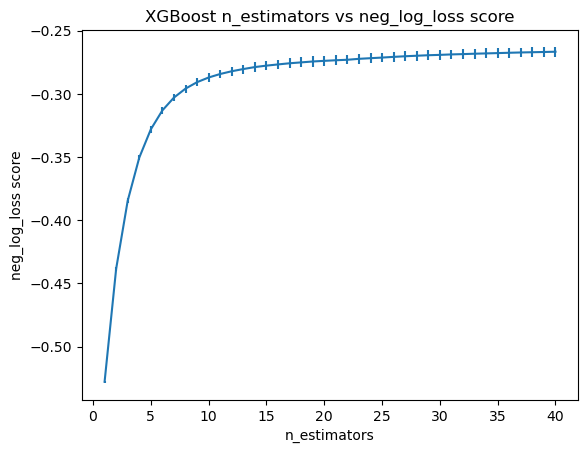

In [20]:
model = XGBClassifier(objective='binary:logistic')
n_estimators = range(1, 41, 1)
param_grid = dict(n_estimators=n_estimators)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
scores = ['f1','neg_log_loss']
for score in scores:
    grid_search = GridSearchCV(model, param_grid, scoring=score, n_jobs=-1, cv=kfold)
    grid_result = grid_search.fit(X_train, y_train)

    # summarize results
    print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    for mean, stdev, param in zip(means, stds, params):
     print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(n_estimators, means, yerr=stds)
    plt.title(f"XGBoost n_estimators vs {score} score")
    plt.xlabel('n_estimators')
    plt.ylabel(f'{score} score')
    plt.savefig('n_estimators.png')
    plt.show()

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.908076 using {'max_depth': 6}, 1 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.909895 using {'max_depth': 11}, 6 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.910085 using {'max_depth': 11}, 11 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.910126 using {'max_depth': 11}, 16 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.910142 using {'max_depth': 11}, 21 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.910101 using {'max_depth': 11}, 26 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.909899 using {'max_depth': 11}, 31 estimators and f1 score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: 0.909699 using {'

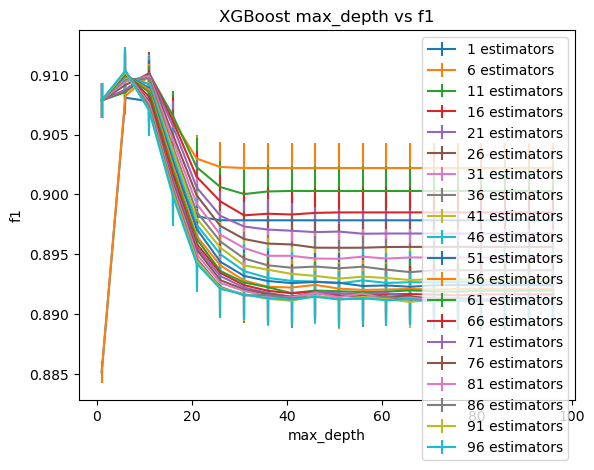

Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.523147 using {'max_depth': 16}, 1 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.302119 using {'max_depth': 11}, 6 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.272935 using {'max_depth': 11}, 11 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.267207 using {'max_depth': 11}, 16 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.265254 using {'max_depth': 11}, 21 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.264487 using {'max_depth': 11}, 26 estimators and neg_log_loss score 
Fitting 10 folds for each of 20 candidates, totalling 200 fits
Best: -0.264249 using {'max_depth': 11}, 31 estimators and neg_log_loss score 
Fitting 

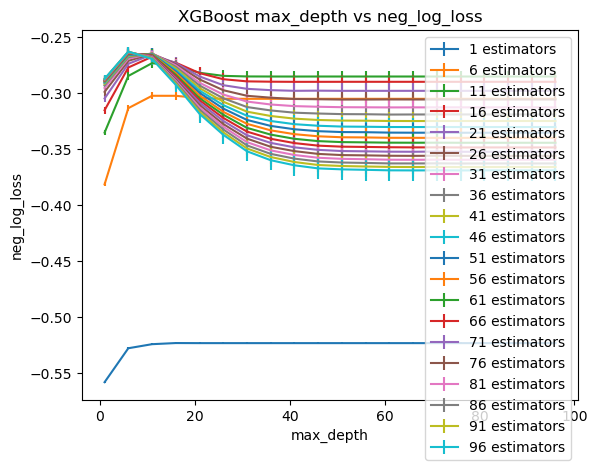

In [21]:
max_depth = range(1, 100, 5)
n_estimators = range(1, 100, 5)
param_grid = dict(max_depth=max_depth)
kfold = StratifiedKFold(n_splits=10, shuffle=True, random_state=10)
scores = ['f1','neg_log_loss']
plotted = False
for score,n_estimator in [(score,n_estimator) for score in scores for n_estimator in n_estimators]:
    if score == 'neg_log_loss' and not(plotted):
        plt.show()
        plotted=True
    model = XGBClassifier(objective='binary:logistic',n_estimators=n_estimator)
    grid_search = GridSearchCV(model, param_grid, scoring=score, n_jobs=-1, cv=kfold, verbose=1)
    grid_result = grid_search.fit(X_train, y_train)
    # summarize results
    print("Best: %f using %s, %s estimators and %s score " % (grid_result.best_score_, grid_result.best_params_,n_estimator,score))
    means = grid_result.cv_results_['mean_test_score']
    stds = grid_result.cv_results_['std_test_score']
    params = grid_result.cv_results_['params']
    #for mean, stdev, param in zip(means, stds, params):
     #print("%f (%f) with: %r" % (mean, stdev, param))
    # plot
    plt.errorbar(max_depth, means, yerr=stds, label=f"{n_estimator} estimators")
    plt.title(f"XGBoost max_depth vs {score}")
    plt.xlabel('max_depth')
    plt.ylabel(score)
    leg = plt.legend()
plt.show()

In [35]:
depths = [4,11,6,6,11,6,6]
estimators = [12,21,71,96,31,66,16]
y_test
for depth,estimator in zip(depths,estimators):
    clf_xgb = XGBClassifier(objective = 'binary:logistic',max_depth=depth,n_estimators=estimator, seed=10, eval_metric="error")
    pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=10, eval_set=[(X_test, y_test)],verbose=False)
    preds_xgb = clf_xgb.predict(X_test)
    accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]
    print('Accuracy de XGBoost: ', accuracy_xgb)
    print('Matthews correlation coeficient: ',matthews_corrcoef(y_test,preds_xgb))



Accuracy de XGBoost:  0.8823083755682115
Matthews correlation coeficient:  0.7749766415912116
Accuracy de XGBoost:  0.886174826270965
Matthews correlation coeficient:  0.7764310741404626
Accuracy de XGBoost:  0.8843199749203198
Matthews correlation coeficient:  0.7775693038432787
Accuracy de XGBoost:  0.8843199749203198
Matthews correlation coeficient:  0.7775693038432787
Accuracy de XGBoost:  0.8871153142797429
Matthews correlation coeficient:  0.7779514020976755
Accuracy de XGBoost:  0.8843199749203198
Matthews correlation coeficient:  0.7775693038432787
Accuracy de XGBoost:  0.8843199749203198
Matthews correlation coeficient:  0.7775693038432787


In [27]:
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score, roc_curve, confusion_matrix, average_precision_score, precision_recall_curve

def _threshold_finder(model, X, y_true):
    """
    a function to find the optimal threshold for binary classification
    model: a trained model object (such as xgboost, glmnet, ...)
    X: the test set of features (pandas dataframe or numpy array)
    y_true: the true class labels (list or array of 0's and 1's)    
    """
    
    y_predict_proba = model.predict_proba(X)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true, y_predict_proba)
    auc = roc_auc_score(y_true, y_predict_proba)
    precision, recall, thresholds2 = precision_recall_curve(y_true, y_predict_proba)
    
    class_names = [0, 1]
    youden_idx = np.argmax(np.abs(tpr - fpr))
    youden_threshold = thresholds[youden_idx]
    y_pred_youden = (y_predict_proba > youden_threshold).astype(int)
    cnf_matrix = confusion_matrix(y_true, y_pred_youden)
    np.set_printoptions(precision=2)
    
    f1 = []
    for i in range(len(precision)):
        f1.append(2 * (precision[i] * recall[i]) / (precision[i] + recall[i]))
        
    queue_rate = []
    for thr in thresholds2:
        queue_rate.append((y_predict_proba >= thr).mean()) 

    plt.figure(figsize = (10, 5))
    plt.subplot(1,2,1)
    plt.plot(fpr, tpr, color = "red", label = F"AUC = {auc:.3f}")
    plt.plot(fpr[youden_idx], tpr[youden_idx], marker = "o", color = "navy", ms =10, label =F"Youden Threshold = {youden_threshold:.2f}" )
    plt.axvline(x = fpr[youden_idx], ymin = fpr[youden_idx], ymax = tpr[youden_idx], color = "navy", ls = "--")
    plt.plot([0,1], [0,1] , color = "black", ls = "--")
    plt.xlim([-0.01, 1.01])
    plt.ylim([-0.01, 1.01])
    plt.xlabel('1 - Specificity' , fontsize=12)
    plt.ylabel('Sensitivity' , fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=12)
    plt.legend( prop={'size':12} , loc = 4)

    plt.subplot(1,2,2)
    _plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = False, cmap=plt.cm.Reds, title = F"Youden Threshold = {youden_threshold:.2f}\nAccuracy = {accuracy_score(y_true, y_pred_youden)*100:.2f}%")
    plt.show()
    
    plt.figure(figsize = (12, 5))
    plt.subplot(1,2,1)
    plt.plot(thresholds, 1-fpr, label = "1 - Specificity")
    plt.plot(thresholds, tpr, label = "Sensitivity")
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds[np.argmin(abs(tpr + fpr - 1))]+0.2])
    plt.axvline(thresholds[np.argmin(abs(tpr + fpr - 1))], color="k", ls = "--")
    plt.title(F"Threshold = {thresholds[np.argmin(abs(tpr + fpr - 1))]:.3f}", fontsize = 12)
    
    plt.subplot(1,2,2)
    plt.plot(thresholds2, precision[1:], label = "Precision")
    plt.plot(thresholds2, recall[1:], label = "Recall")
    plt.plot(thresholds2, f1[1:], label = "F1-Score")
    plt.plot(thresholds2, queue_rate, label = "Queue Rate")
    plt.legend(loc = 0)
    plt.xlim([0.025, thresholds2[np.argmin(abs(precision-recall))] + 0.2])
    plt.xlabel("Threshold", fontsize = 12)
    plt.ylabel("Score", fontsize = 12)
    plt.axvline(thresholds2[np.argmin(abs(precision-recall))], color="k", ls = "--")
    plt.title(label = F"Threshold = {thresholds2[np.argmin(abs(precision-recall))]:.3f}", fontsize = 12)
    plt.show()
    
def _plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Greens):
    from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, roc_curve, auc, confusion_matrix
    import itertools
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title, fontsize = 14)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="black")

    plt.ylabel('True Class', fontsize = 14)
    plt.xlabel('Predicted Class', fontsize = 14)

    plt.tick_params(axis='both', which='major', labelsize=14)
    plt.tight_layout()

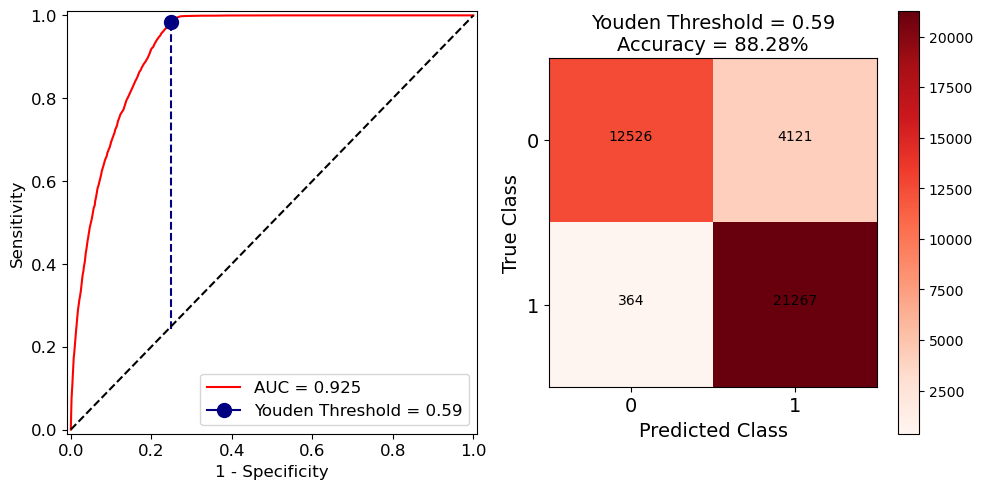

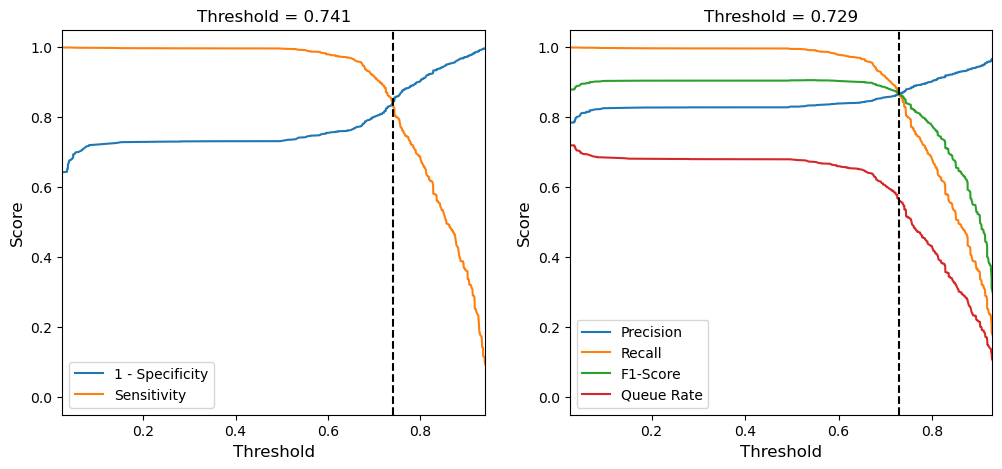

In [28]:
_threshold_finder(model = clf_xgb, X = X_test, y_true = y_test)

In [41]:
clf_xgb = XGBClassifier(objective = 'binary:logistic',max_depth=4,n_estimators=12,seed=10, eval_metric="error@0.5")

thresholds = [0.59, 0.741, 0.729]

pred = clf_xgb.fit(X_train,y_train, early_stopping_rounds=20, eval_set=[(X_test, y_test)])
preds_xgb = clf_xgb.predict(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
preds_xgb_proba = clf_xgb.predict_proba(X_test,iteration_range=(0, clf_xgb.best_iteration + 1))
#print(preds_xgb)
accuracy_xgb = float(np.sum(preds_xgb == y_test))/y_test.shape[0]

print('Accuracy de XGBoost: ', accuracy_xgb)
print('Error: ', 1-accuracy_xgb)
print(matthews_corrcoef(y_test,preds_threshold))

for threshold in thresholds:
    preds_threshold = (preds_xgb_proba[:,1] >= threshold).astype(int)
    #print(preds_threshold)
    accuracy_xgb = float(np.sum(preds_threshold == y_test))/y_test.shape[0]
    print(f'Accuracy de XGBoost con {threshold} de threshold: ', accuracy_xgb)
    print('Error: ', 1-accuracy_xgb)
    print(matthews_corrcoef(y_test,preds_threshold))

[0]	validation_0-error@0.54:0.11874
[1]	validation_0-error@0.54:0.11874
[2]	validation_0-error@0.54:0.11874
[3]	validation_0-error@0.54:0.11874
[4]	validation_0-error@0.54:0.11874
[5]	validation_0-error@0.54:0.11874
[6]	validation_0-error@0.54:0.11874
[7]	validation_0-error@0.54:0.11874
[8]	validation_0-error@0.54:0.11806
[9]	validation_0-error@0.54:0.11733
[10]	validation_0-error@0.54:0.11633
[11]	validation_0-error@0.54:0.11649
Accuracy de XGBoost:  0.8812895135587021
Error:  0.11871048644129789
0.7667801620006683
Accuracy de XGBoost con 0.59 de threshold:  0.8830921155755264
Error:  0.11690788442447364
0.7732666562479208
Accuracy de XGBoost con 0.741 de threshold:  0.8268195830503161
Error:  0.1731804169496839
0.6555203771133228
Accuracy de XGBoost con 0.729 de threshold:  0.8498876639322849
Error:  0.15011233606771512
0.6945683114642962
